In [1]:
!nvidia-smi

Tue Aug 16 10:28:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:8A:00.0 Off |                    0 |
| N/A   35C    P0    42W / 300W |      9MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:B2:00.0 Off |                    0 |
| N/A   

# Sparse Neural Additive Models (SNAM)
Yang et al, 2021

# Set up

## Tensorboard in notebook

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import datetime, os

In [ ]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5816), started 0:03:29 ago. (Use '!kill 5816' to kill it.)

In [ ]:
## Train a simple NN to demonstrate tensorboard
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

In [ ]:
def train_model():

  model = create_model()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  # tensorboard cmds to log metrics
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(x=x_train, 
            y=y_train, 
            epochs=5, 
            validation_data=(x_test, y_test), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4979 - accuracy: 0.8216 - val_loss: 0.4836 - val_accuracy: 0.8219
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3834 - accuracy: 0.8587 - val_loss: 0.3864 - val_accuracy: 0.8633
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3507 - accuracy: 0.8703 - val_loss: 0.3870 - val_accuracy: 0.8567
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3295 - accuracy: 0.8783 - val_loss: 0.3623 - val_accuracy: 0.8668
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3124 - accuracy: 0.8832 - val_loss: 0.3440 - val_accuracy: 0.8777


## basic imports

In [3]:
# for bw uni -cluster
#!module add jupyter/tensorflow
#wandb.finish()

In [2]:
# activate venv & log into wandb
!source ml-env/bin/activate
#!pip install wandb -qq 
import wandb
wandb.login()
#wandb.init(project="interpretable-ml", group="snam-studies")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m-janyellow. Use `wandb login --relogin` to force relogin


True

In [3]:
## Set up Gdrive to work with Colab
root_path = ""

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    root_path = "/content/drive/MyDrive/ml-seminar/data/"
    drive.mount("/content/drive")
else:
    root_path = "./data/"

print(root_path)

./data/


In [4]:
import time
from tqdm import tqdm
import pandas as pd
from scipy.stats import pearsonr
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import sklearn.datasets, sklearn.preprocessing, sklearn.model_selection
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import GradientBoostingRegressor
import copy
from numpy import linalg as LA
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score,roc_curve,precision_score,recall_score
#from torchvision import datasets, transforms
import statistics as stats
from sklearn import svm
from sklearn import linear_model
from sklearn.datasets import fetch_california_housing
import pickle

## Set up device for training 
- cloud TPUs or
- GPUs

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

In [ ]:
# imports pytorch
import torch

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

In [ ]:
# Creates a random tensor on xla:1 (a Cloud TPU core)
device = xm.xla_device()
t1 = torch.ones(3, 3, device = device)
print(t1)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='xla:1')


## GPU

In [21]:
## if no tpu

import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
def l1(x):
    return torch.sum(abs(x))
def ExU(x, w, b):
    return torch.matmul(torch.exp(w), x-b)
def groupl1(x):
    return torch.norm(x)
def sign(m):
    return torch.sign(m)

# Data Loading and Preprocessing

In [4]:
#path = "/content/drive/MyDrive/ml-seminar/data"

In [8]:
random_state=1
def load_data(data_dir, train_mode=False, save=False, pickle=False, feature_selector=False):
    # parse dates to datetime in format YY-MM-DD before loading
    dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors='coerce')
    
    if pickle:
      data = pd.read_pickle(path + data_dir)
    else:
      data = pd.read_csv(path + data_dir, parse_dates=['date'], 
                       index_col=['date', 'permno'], date_parser=dateparse, skipinitialspace=True)
    if feature_selector!=False:
      data = data.loc[:, feature_selector]
    
    # isolate target
    X = data.iloc[:,:-1]
    y = data.TARGET
    
    if save:
      X.to_csv(data_dir + 'X' + train_mode + 'csv')
      y.to_csv(data_dir + 'X' + train_mode + 'csv')
    
    ## split data along the timeline
    # define train, val, test window
    start_of_training = "1975-01-01"  #data.index.get_level_values(0).min()
    end_of_training="1995-12-31"
    end_of_validation="2000-12-31"
    
    # define initial training and test window
    train_window = pd.date_range(start=start_of_training, end=end_of_training, freq="M")
    train_window = len(train_window)

    # slice to required size
    X_train = X.loc[pd.IndexSlice[start_of_training:end_of_training,], :]
    y_train = y.loc[pd.IndexSlice[start_of_training:end_of_training,]]
    X_valid = X.loc[pd.IndexSlice[end_of_training:end_of_validation,], :]
    y_valid = y.loc[pd.IndexSlice[end_of_training:end_of_validation,]]
    X_test = X.loc[pd.IndexSlice[end_of_validation:,], :]
    y_test = y.loc[pd.IndexSlice[end_of_validation:,]]

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [8]:
# Load subsample
subsample_path = '/subsample_processed_scaled.csv'
subsample_large = '/subsample_processed_scaled_500.csv'
fullsample_path = '/data_processed_scaled.csv'
#subsample = load_data(subsample_path, pickle=False)
#X_train, X_valid, X_test, y_train, y_valid, y_test = load_data(subsample_large, pickle=False)

In [ ]:
print(f'Start of training set: {X_train.index.min()}')
print(f'End of training set: {X_train.index.max()}')
print(f'Start of valid set: {X_valid.index.min()}')
print(f'End of valid set: {X_valid.index.max()}')

Start of training set: (Timestamp('1963-07-31 00:00:00'), 19940)
End of training set: (Timestamp('1975-12-31 00:00:00'), 68195)
Start of valid set: (Timestamp('1976-01-31 00:00:00'), 10006)
End of valid set: (Timestamp('1976-12-31 00:00:00'), 68195)


## preprocessing methods for artificial data (not applicable here)

In [36]:
#%%Three methods for preprocessing datasets from Shiyun Xu (2022)
### TO-DO: insert preprocessing method (s)
### Not needed data is already preprocessed
def gen_data_center(features,n_samples, n_fake_features, sigma, nseed=1, save=False):

    np.random.seed(nseed)
    
    n_true_features = len(features)

    noise = sigma*np.random.randn(n_samples)
    temp_y=[]
    X = np.random.randn(n_samples, n_features)
    y = np.hstack([feature(X[:, [i]]) for i, feature in enumerate(features)]).sum(axis=1)+noise
	
    X -= X.mean(axis=0)
    X /= X.std(axis=0)	
    y -= y.mean()
    
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test 


def gen_data_normal(features,n_samples, n_fake_features, sigma, nseed=1, save=False):

    np.random.seed(nseed)
    
    n_true_features = len(features)

    noise = sigma*np.random.randn(n_samples)
    temp_y=[]
    X = np.random.randn(n_samples, n_features)
    for i, feature in enumerate(features):
        temp=feature(X[:, [i]])
        new_temp = (temp-np.min(temp))/(np.max(temp)-np.min(temp))
        temp_y.append(new_temp)
    y = np.hstack(temp_y).sum(axis=1)+noise

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test 


def gen_data_cls(features,n_samples, n_fake_features, nseed=1, save=False):

    np.random.seed(nseed)
    
    n_true_features = len(features)
    n_features = n_true_features + n_fake_features

    X = np.random.randn(n_samples, n_features)
    temp = np.hstack([feature(X[:, [i]]) for i, feature in enumerate(features)]).sum(axis=1)
    # temp -= np.mean(temp)
    
    y = [(np.random.binomial(size=1, n=1, p=1.0/(1+np.exp(-logit)))).item() for logit in \
                  temp] 
    y=np.asarray(y)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test 

## weiter geht's

In [9]:
def data_totensor2(X_train, X_test, y_train, y_test, batch_size = 256, batch_size_test=1000,save=False, MSE=True):
    
    #%% separate data into three parts: train, validation(?) and test. 
    if MSE: 
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)
        D_out = 1
    else:
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).long()
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).long()
        D_out = 2

    Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=False)
    Test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size_test, shuffle=False)
    
    if save== True:
        f = open(path+"data/p2_data.pkl","wb")
        pickle.dump([trainloader, valloader, testloader, D_out], f)
        f.close()
    
    return trainloader, testloader, D_out

## basic data exploration

In [ ]:
for i in X_train.columns:
    plt.scatter(X_train[i], y_train)
    plt.title(i)
    plt.show()

# Model & Train

In [10]:
class SampleNet(nn.Module):
    def __init__(self,seed=1, m=100, n_output=1):
        super().__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        # self.fc0 = nn.Linear(1, 1,bias=False)
        self.fc1 = nn.Linear(1, m)
        self.fc2 = nn.Linear(m, 50)
        self.fc3 = nn.Linear(50, n_output, bias=False)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x)))).to(device)
        return self.fc3(x)

    def name(self):
        return "CaliforniaNAM_FeatureNN"

In [11]:
class PyramidNet(nn.Module):
    def __init__(self,seed=1, m=64, n_output=1):
        super().__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        # self.fc0 = nn.Linear(1, 1,bias=False)
        self.fc1 = nn.Linear(1, m)
        self.fc2 = nn.Linear(m, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, n_output, bias=False)

    def forward(self, x):
        x = F.relu(self.fc4(F.relu(self.fc3(F.relu(self.fc2(F.relu(self.fc1(x))))))))
        return self.fc5(x)

    def name(self):
        return "PyramidNAM_FeatureNN"

In [12]:
class NAM(nn.Module):
    def __init__(self, feature_size, output_size, ModelA, seed=1, m=100):
        super(NAM, self).__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        self.feature_size = feature_size
        self.output_size = output_size
        self.feature_nns = torch.nn.ModuleList([
            ModelA(seed=seed, m=m, n_output=output_size)
            for i in range(feature_size)
        ])
        self.bias = nn.Parameter(torch.zeros(output_size), requires_grad=True)

        
    def forward(self, input):

        output=self.feature_nns[0](input[:, [0]])+self.bias # input layer
        for i in range(1,self.feature_size):                # hidden layers
            output+=self.feature_nns[i](input[:,[i]])       # add layer output to total output
        # f_out is output of the subnetwork for the i-th feature 
        f_out=torch.cat([self.feature_nns[i](input[:, [i]]).reshape(len(input), -1, output_size)
         for i in range(self.feature_size)], dim=1)         # output one value per feature
        return [output, f_out]                              # total output is sum
                                                            # of f-outputs
    def name(self):
        return "CaliforniaNAM"

In [9]:
## TO-DO: What exactly happens here?? Where is group lasso? introduce early stopping!

#from torch.optim.lr_scheduler import ExponentialLR

def train_sub(trainloader, testloader,n_features, model, optimizer,max_epoch,
          torch_seed=0, test=False, lbd=0.1, MSE=False):
    
    print("################################## START OF TRAINING ##################################")
    n_layer=0
    for name, param in model.named_parameters():
        if 'feature_nns.0' in name and 'weight' in name:
            n_layer+=1
    
    model.train()
    
    if MSE==True:
      criterion=torch.nn.MSELoss()
    else:
      criterion=torch.nn.CrossEntropyLoss()
    
    # save model and loss metrics
    save_dir = "./models/SNAM/"
    epoch_train_loss_history = []
    epoch_test_loss_history = []
    
    # adaptive lr
    #scheduler = ExponentialLR(optimizer, gamma=0.6)
    
    early_stopping = EarlyStopping(tolerance=2, min_delta=0)
    
    for epoch in range(max_epoch):
        if (epoch)%5==0:
            print(f"##### Training Epoch Nr: {epoch} started ####")
            print("Early stopping counter: ", early_stopping.counter)
        f_out_tr = []                 # train feature outputs
        total_batch_loss=0
        tr_correct, tr_total = 0, 0
        
        for idx1, (inputs, targets) in tqdm(enumerate(trainloader)): 
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, f_out_tr_temp = model(inputs)[0],model(inputs)[1].detach().cpu().numpy()
            f_out_tr.append(f_out_tr_temp)
            loss=criterion(outputs, targets)
            total_batch_loss += loss.item()

            if MSE == False:
                tr_correct += (torch.argmax(outputs, axis=1) == targets).sum().item()
                tr_total += len(targets)      
            #%%%%%%%%%%%add regularization%%%%%%%%%%%#
            for ind in range(n_features):
                count=1
                reg_loss = torch.tensor(0).float().to(device)
                for name, param in model.named_parameters():                        
                    if 'weight' in name and name.find('feature_nns.'+str(ind)) == 0: 
                        if  count == n_layer: 
                            reg_loss+=groupl1(param.T) 
                        count+=1
                loss += lbd*torch.sqrt(reg_loss)
            loss.backward()
            optimizer.step()
        #if epoch%10==0:
        #    scheduler.step()
        #    for g in optimizer.param_groups:
        #        wandb.log({"current_lr" : g['lr']})


        if test==True:
            model.eval()
            test_loss = 0
            test_correct, test_total = 0, 0
            with torch.no_grad():
                for idx2, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs, f_out_te = model(inputs)[0], model(inputs)[1].detach().cpu().numpy()
                    test_loss += criterion(outputs, targets).item()
                    if MSE == False:
                        test_correct += (torch.argmax(outputs, axis=1) == targets).sum().item()
                        test_total += len(targets)
                test_loss = test_loss/(idx2+1)
                if (epoch+1)%10==0:
                    print(f"test loss : {test_loss}")

        
        if (epoch+1)%10==0:
            if MSE == False:
                print('epoch: ', epoch+1, 'Loss train: ', total_batch_loss/(idx1+1), 'ACC train: ', 100*(tr_correct/tr_total))
                print('Loss test: ', test_loss, 'ACC test: ', 100*(test_correct/test_total))
            else:
                print('epoch: ', epoch+1, 'Loss train: ', total_batch_loss/(idx1+1), 'Loss test: ', test_loss)
                # log metric to tensorboard
                #writer.add_scalar("Train Loss", total_batch_loss/(idx1+1), epoch)
                #writer.add_scalar('Loss test: ', test_loss, epoch)
        wandb.log({"Train Loss" : total_batch_loss/(idx1+1),
                           'Loss test: ' : test_loss})
        # save metrics to list for plotting
        epoch_train_loss_history.append(total_batch_loss/(idx1+1))
        epoch_test_loss_history.append(test_loss)
         
        # save model
        torch.save(model,  save_dir+'model_87.pth') # wandb run id
        
        # early stopping
        early_stopping(total_batch_loss, test_loss)
        
        if early_stopping.early_stop:
          print("Early stopping at epoch:", epoch)
          break
        
    #%%%%%%%%%%%%%%%%%%%%%#
    # for support recovery
    # model.eval()
    # test_loss = 0
    # f_out_te = []
    # with torch.no_grad():
    #     for idx, (inputs, targets) in enumerate(testloader):
    #         inputs, targets = inputs.to(device), targets.to(device).reshape(-1)
    #         outputs, f_out_te_temp = model(inputs)[0], model(inputs)[1].detach().cpu().numpy()
    #         f_out_te.append(f_out_te_temp)
    #         test_loss += criterion(outputs, targets).item()
    #     test_loss = test_loss/(idx+1)
    # print('MSE test: ', test_loss) #, 'f_test_out', np.mean(f_out.cpu().detach().numpy(), axis=0)
    
    # mean_f_out = np.mean(f_out_te.cpu().detach().numpy(), axis=0)
    # select_mean_f_out=[1 if abs(a) > threshold else 0 for a in mean_f_out]
    # print(select_mean_f_out, true_feature)
    # print('auc score: ', roc_auc_score(true_feature,mean_f_out))
    
    if MSE == False:
        return [100*(test_correct/test_total), test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model]
    #writer.flush()
    #writer.close()
    return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model, epoch_train_loss_history, epoch_test_loss_history]

In [10]:
def predict_and_evaluate_model(model, testloader, run_id=None, load=False, wandb_log=True):
    if load:
        model = torch.load('./models/model_'+str(run_id)+'.pth')
    model.eval()
    #model.to('cpu')
    with torch.no_grad():
        for idx2, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device).reshape(-1) #.detach().cpu().numpy()
            outputs, f_out_te = model(inputs)[0].detach().cpu().numpy(), model(inputs)[1].detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
        # Calculate Test metrics: MAE, MSE, RMSE:
        rmse = np.sqrt(((targets - outputs)**2).mean())
        mae = mean_absolute_error(targets, outputs)
        mse = mean_squared_error(targets, outputs)
        if wandb_log:
            wandb.log({"rmse_test" : rmse, "mse_test" : mse, "mae_test" : mae})
    return rmse, mae, mse, outputs, targets, f_out_te

In [11]:
def simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features, output_size,
             opti_name, MSE=False,
             seed=1, RFM=False, pyramid=False):

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # start wandb run
    wandb.init(project="interpretable-ml", group="snam-studies")

    print('training with lbd: ', lbd)
    wandb.log({"learning_rate" : lr, "optimizer" : opti_name, "n_features" : n_features,
               "max_epochs" : max_epoch})
    #print(device)

    #if loaded:
    #    model = model
    if pyramid == True:
        if RFM == True:
            model = RF_Net(NAM(n_features, output_size, PyramidNet, seed=1), n_features).to(device)
            print(f"Training on: {device}") 
        else: 
            model = NAM(n_features, output_size, PyramidNet, seed=1).to(device) #, MSE=MSE
            print(f"Training on: {device}")
    else:
        if RFM == True:
            model = RF_Net(NAM(n_features, output_size, SampleNet,seed=1), n_features).to(device)
            print(f"Training on: {device}") 
        else: 
            model = NAM(n_features, output_size, SampleNet,seed=1).to(device) #, MSE=MSE
            print(f"Training on: {device}")

    if opti_name=='SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
        train_func=train_sub
    elif opti_name=='Adam': 
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        train_func=train_sub
    else:
        print('wrong name. Pls enter one of them: SGD, ADAM, prox.')
        
    result = train_func(trainloader, testloader, n_features, model, optimizer, max_epoch, torch_seed=0, test=True, lbd=lbd, MSE=MSE) #0.8


    return result

### implement early stopping
adopted from [https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch]

In [12]:
## Implement early stopping to prevent model from overfitting
class EarlyStopping():
    def __init__(self, tolerance=10, min_delta=0.15):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) / train_loss > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

## identification error

In [16]:
## What is 'features' ???

def iden_errorML(x, coef, features, plot=False):
    #%% the output is generated bu 
    iden_error_list = []
    for i in range(len(coef)):
        f_i_hat = x[:, i]*coef[i]
        if i <len(features):
            f_i = features[i](x[:, i])
        else: f_i = np.zeros_like(f_i_hat)
        c_i=np.mean(f_i_hat-f_i)
        iden_error_list.append(np.mean((f_i_hat-f_i-c_i)**2))
    if plot == True:
        for i in range(len(coef)):
            f_i_hat = x[:, i]*coef[i]
            if i <len(features):
                f_i = features[i](x[:, i])
            else: f_i = np.zeros_like(f_i_hat)
            plt.scatter(x[:, i], f_i, label='truth')
            plt.scatter(x[:, i], f_i_hat, label='prediction')
            plt.legend()
            plt.show()
    return np.mean(iden_error_list)


def iden_error_spam(X_train, f_tr, features, plot=False):
    iden_error=0
    for i in range(f_tr.shape[1]):
        if i < len(features):
            f_i = y_train ##features[i](X_train[:, [i]]) 
        else: f_i = np.zeros_like(X_train[:, [i]])
        c_i=np.mean(f_tr[:,[i]]-f_i)
        iden_error+=np.mean((f_tr[:, [i]]-f_i-c_i)**2)

        if plot == True:
            plt.scatter(X_train.iloc[:, i], f_tr[:, [i]]-c_i, label='SNAM')
            plt.scatter(X_train.iloc[:, i], f_i, label='Truth')
            plt.legend()
            plt.xlabel("x")
            plt.ylabel("f(x)")
            plt.show()
    # print('iden error: ', iden_error/len(features))
    return iden_error/len(features)

In [17]:
def RF_Net(model, n_features):
    n_layer=0
    for name, param in model.named_parameters():
        if 'feature_nns.0' in name and 'weight' in name:
            n_layer+=1
    for ind in range(n_features):
        count=1
        for name, param in model.named_parameters():    
            if 'weight' in name and name.find('feature_nns.'+str(ind)) == 0: 
                # print(name,count)
                if  count != n_layer:
                    param.requires_grad = False 
                count+=1
            elif 'bias' in name:
                param.requires_grad = False 
    
    return model

In [15]:
###% test
#n_features
model = RF_Net(NAM(5, 1, SampleNet).to(device), 5)
for name, param in model.named_parameters():
  if param.requires_grad == True:
    print(name)

feature_nns.0.fc3.weight
feature_nns.1.fc3.weight
feature_nns.2.fc3.weight
feature_nns.3.fc3.weight
feature_nns.4.fc3.weight


## Other models (l1-SVM, Lasso, etc.)

### l1_SVM

#### classification

In [ ]:
#!git clone https://github.com/ShiyunXu/SNAM

Cloning into 'SNAM'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 45 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [ ]:
#data_name = 'data_cls'
#[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))
start = time.time()

lin_clf = svm.LinearSVC(penalty='l1', dual=False, C=0.02)
lin_clf.fit(X_train, y_train)
y_test_pred = lin_clf.predict(X_test)
time_spent =  time.time()-start 

# iden_loss = iden_error(X_test, lin_clf.coef_.reshape(-1), features, plot=True)

print('f_train_out: ', lin_clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_test)**2))
print('test acc: ', lin_clf.score(X_test, y_test))
print('precision: ', precision_score(true_feature,abs(lin_clf.coef_.reshape(-1))>0.01))
print('recall: ', recall_score(true_feature,abs(lin_clf.coef_.reshape(-1))>0.01))
# print('iden error: ', iden_loss)

#### regression

In [ ]:
#data_name='data_rg'
#[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))
start = time.time()

lin_clf = svm.LinearSVR(C=0.1)
lin_clf.fit(X_train, y_train)
# dec = lin_clf.decision_function(X_test)
y_test_pred = lin_clf.predict(X_valid) # /X_test
time_spent =  time.time()-start 



#iden_loss = iden_errorML(X_valid, lin_clf.coef_, features=X_train.columns, plot=True) #/X_test

print('f_train_out: ', lin_clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_valid)**2)) # /y_test
print('precision: ', precision_score(y_test,abs(lin_clf.coef_.reshape(-1))>0.01))
print('recall: ', recall_score(y_test,abs(lin_clf.coef_.reshape(-1))>0.01))
#print('iden error: ', iden_loss)

In [ ]:
### SKIP for now
##%%save
# f = open(path+"plot_synRG_l1svm.pkl","wb")
# pickle.dump([lin_clf.coef_, lin_clf], f)
# f.close()

##%%load
[lin_clf.coef_, lin_clf] = \
pickle.load(open(path+"plot_synRG_l1svm.pkl", "rb"))

In [ ]:
## X_train.iloc[:, 1]

date        permno
1964-07-31  13354     0.045187
            17224     0.417154
            18075     1.173258
            18382     0.984911
            19561     1.670436
                        ...   
1983-12-31  61022     1.468689
            70552     0.122283
            70578    -0.346981
            70790    -0.599315
            74406     2.050857
Name: cum_return_6_2, Length: 7388, dtype: float64

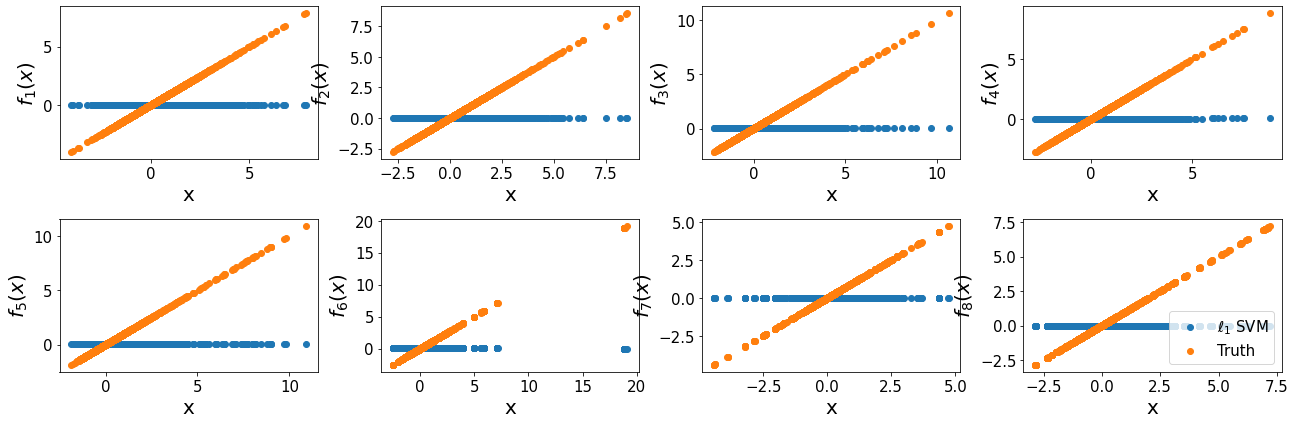

In [ ]:
# replaced 'features' with X_train - did I mess up?! :D

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

i = 0
for row in axes:
    for col in row:
        if i < len(X_train):
            f_i = (X_train.iloc[:, i])
        else: 
            f_i = np.zeros_like(X_train[:, i])
        f_i_hat = X_train.iloc[:, i]*lin_clf.coef_[i]
        c_i=np.mean(f_i_hat-f_i) 
        col.scatter(X_train.iloc[:, i], f_i_hat-c_i, label=r'$\ell_1$ SVM')
        col.scatter(X_train.iloc[:, i], f_i, label='Truth')
        if i == 7:
            col.legend(fontsize='15', loc=4)
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel('x', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig(path+'plot_synRG_l1svm.pdf', bbox_inches='tight')
plt.show()        

### LASSO

#### classification

In [ ]:
#data_name = 'data_cls'
#[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))

start = time.time()

clf = LogisticRegression(C=0.04,penalty='l1', solver='saga')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
time_spent =  time.time()-start 

# iden_loss = iden_error(X_test, clf.coef_.reshape(-1), features, plot=True)

print('f_train_out: ', clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_test)**2))
print('test acc: ', clf.score(X_test, y_test))
print('precision: ', precision_score(true_feature,abs(clf.coef_.reshape(-1))>0.01))
print('recall: ', recall_score(true_feature,abs(clf.coef_.reshape(-1))>0.01))
# print('iden error: ', iden_loss)

#### regression

In [ ]:
#data_name = 'data_rg'
#[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))
start = time.time()

clf = Lasso(alpha=0.5)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_valid)
time_spent =  time.time()-start 

#iden_loss = iden_errorML(X_train, clf.coef_, features, plot=True)
print('f_train_out: ', clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_valid)**2))
print('precision: ', precision_score(true_feature,abs(clf.coef_)>0.01))
print('recall: ', recall_score(true_feature,abs(clf.coef_)>0.01))
#print('iden error: ', iden_loss)

f_train_out:  [ 0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0.  0. -0.  0. -0.  0.  0. -0.  0.  0.  0. -0.
 -0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0.
 -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.  0. -0.  0.]
time spent:  0.1561298370361328  sec
test loss:  0.010845024276192229


NameError: ignored

In [ ]:
##%%save
# f = open(path+"plot_synRG_lasso.pkl","wb")
# pickle.dump([clf.coef_, clf], f)
# f.close()

# ##%%load
[clf.coef_, clf] = \
pickle.load(open(path+"plot_synRG_lasso.pkl", "rb"))

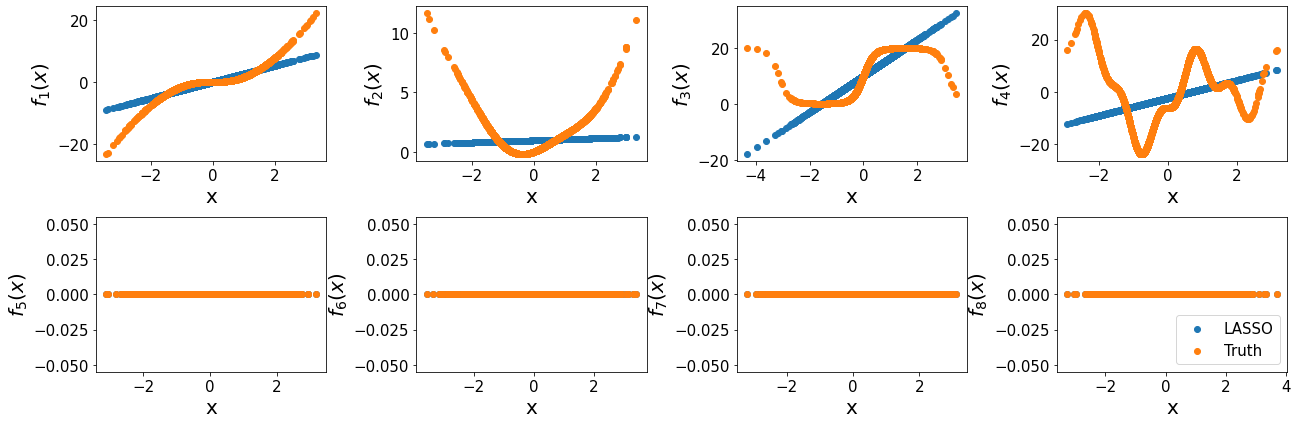

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

i = 0
for row in axes:
    for col in row:
        if i < len(features):
            f_i = features[i](X_train[:, i])
        else: 
            f_i = np.zeros_like(X_train[:, i])
        f_i_hat = X_train[:, i]*clf.coef_[i]
        c_i=np.mean(f_i_hat-f_i) 
        col.scatter(X_train[:, i], f_i_hat-c_i, label='LASSO')
        col.scatter(X_train[:, i], f_i, label='Truth')
        if i == 7:
            col.legend(fontsize='15', loc=4)
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel('x', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig(path+'plot_synRG_lasso.pdf', bbox_inches='tight')
plt.show()        

### SPAM
https://gist.github.com/fabianp/10349186

#### regression

In [ ]:
!pip install moepy --no-dependencies
# !pip install matplotlib==3.1.3
from math import ceil
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from moepy import lowess



"""
Implements the Sparse additive models described in Ravikumar, Pradeep D., et al. 
"SpAM: Sparse Additive Models." NIPS. 2007.
"""
# from loess import lowess


# VERBOSE = 10


def spam_coord_descent(X_train, X_test, y_train, y_test, alpha=1., max_iter=1000, tol=1e-2, f_tr_init=None,
                       ):#loess_f=2. / 3., loess_iter=3

    n_tr_samples, n_tr_features = X_train.shape
    inv_sqrt_n_tr_samples = 1. / np.sqrt(n_tr_samples)

    n_te_samples, n_te_features = X_test.shape
    inv_sqrt_n_te_samples = 1. / np.sqrt(n_te_samples)

    # initialize some variables
    outer_iteration_counter = 0

    # if f_init is None, set it to 0
    if f_tr_init is None:
        f_tr = np.zeros([n_tr_samples, n_tr_features], dtype=X_train.dtype)
    else:
        f_tr = f_tr_init.copy()

    # calculate residue
    R_tr = y_train - f_tr.sum(axis=1)

    while outer_iteration_counter < max_iter:
        R_tr_old = R_tr.copy()
        outer_iteration_counter += 1
        y_hat_test=0
        # poly=[]
        lowess_func_list = []
        for j in range(n_features):
            R_tr += f_tr[:, j]

            lowess_modelj = lowess.Lowess()
            lowess_modelj.fit(X_train[:, j], R_tr) #, frac=0.25
            P_tr_j = lowess_modelj.predict(X_train[:, j])
            # print(P_tr_j)
            lowess_func_list.append(lowess_modelj)

            s_tr_j = inv_sqrt_n_tr_samples * np.sqrt((P_tr_j ** 2).sum())

            # soft threshold
            soft_thresh = 1. - alpha / s_tr_j
            if soft_thresh > 0:
                f_tr_j = soft_thresh * P_tr_j
                f_tr_j -= f_tr_j.mean()
                f_tr[:, j] = f_tr_j[:]
                R_tr[:] -= f_tr_j[:]
            else:
                f_tr[:, j] = 0.

        max_inc = linalg.norm(R_tr-R_tr_old) 
        tr_error = np.mean((np.sum(f_tr, axis=1)-y_train)**2)
        print('MSE_tr', tr_error)

        
        if max_inc < tol / 2:
            break

    f_te = np.zeros([n_te_samples, n_tr_features], dtype=X_train.dtype)    
    for j in range(n_features):
    #%%% test error for y
        P_te_j = lowess_func_list[j].predict(X_test[:, j])
        s_te_j = inv_sqrt_n_te_samples * np.sqrt((P_te_j ** 2).sum())
        # soft threshold
        soft_thresh = 1. - alpha / s_te_j
        if soft_thresh > 0:
            f_te_j = soft_thresh * P_te_j
            f_te_j -= f_te_j.mean()
            f_te[:, j] = f_te_j[:]

        else:
            f_te[:, j] = 0.
    
    temp_mean = np.mean(np.sum(f_tr, axis=1)-y_train)
    te_error = np.mean((np.sum(f_te, axis=1)-y_test-temp_mean)**2)

    # te_error = np.mean((np.sum(f_te, axis=1)-y_test)**2)
    print('MSE_te', te_error)


    return te_error, f_tr, f_te

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


MSE_tr 3.1659856427832755
MSE_te 1.1064697771064356


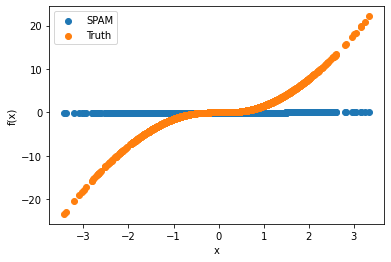

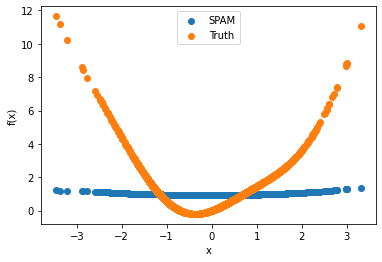

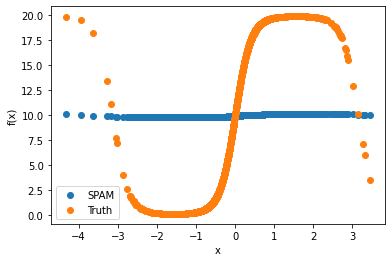

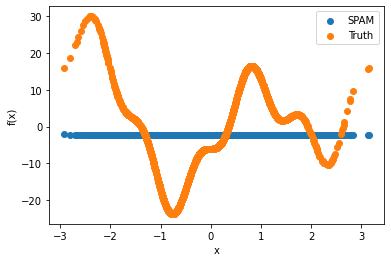

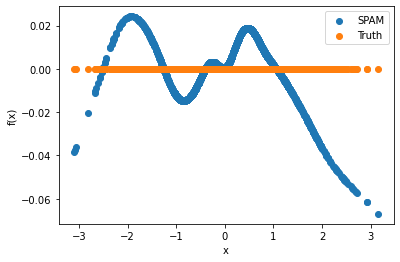

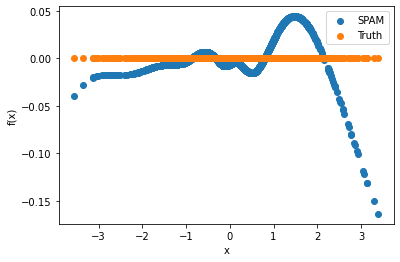

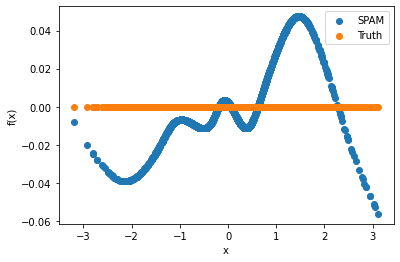

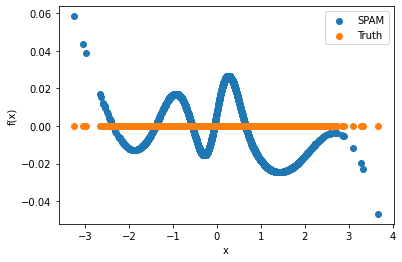

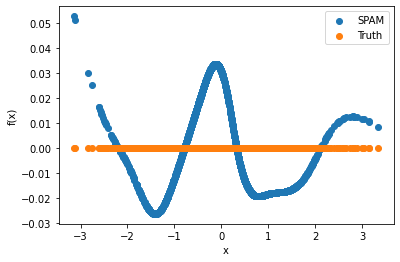

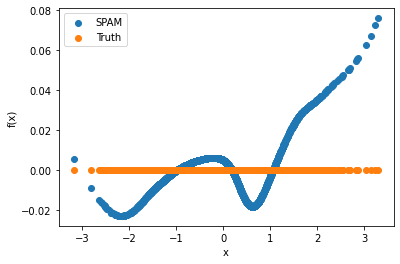

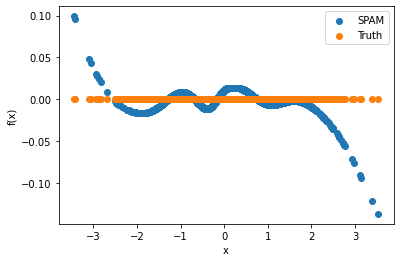

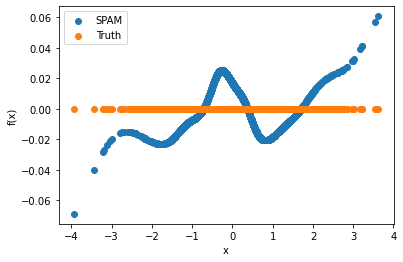

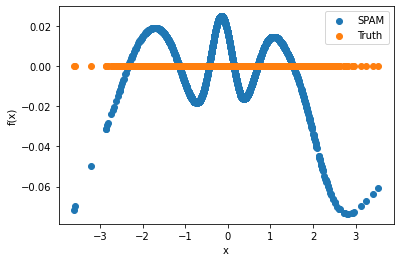

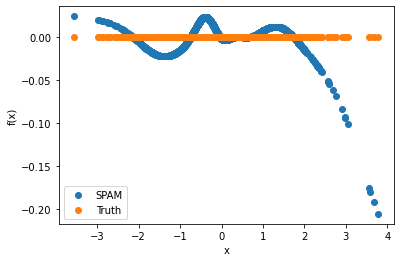

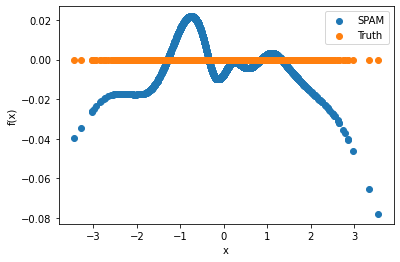

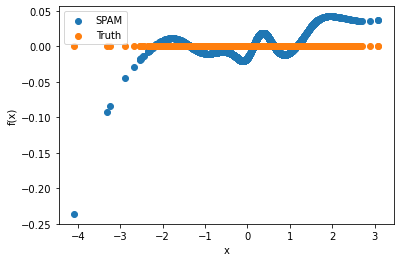

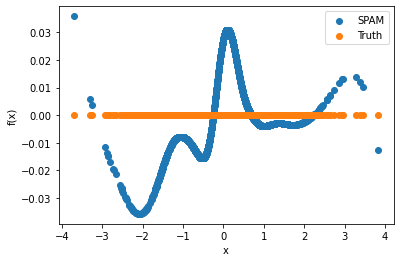

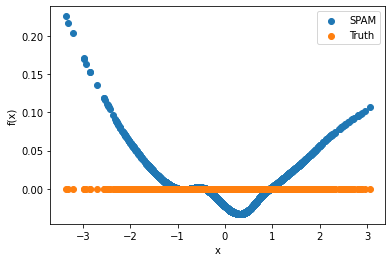

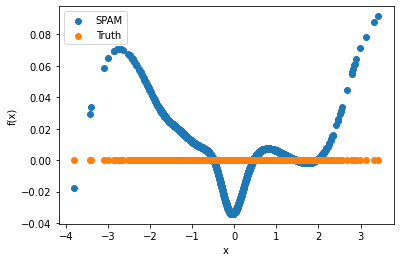

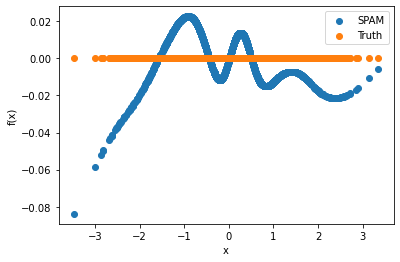

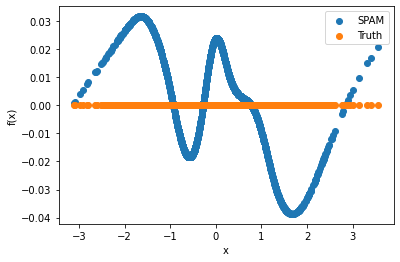

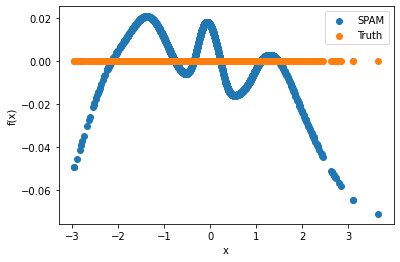

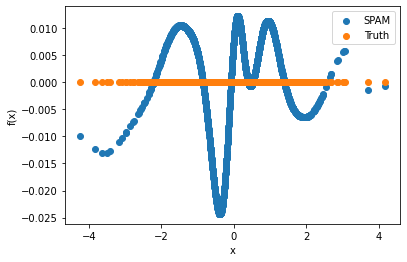

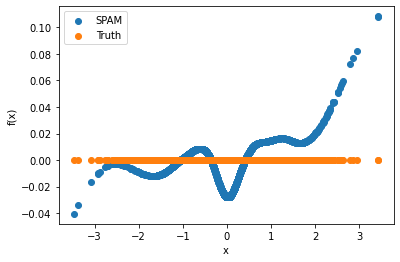

f_train_out [ 1.79717352e-17 -1.19348975e-17  2.40548322e-17  1.64220489e-18
  2.03540888e-17  8.88178420e-18 -5.72921340e-17  6.46704912e-17
  3.16644858e-17  3.77707125e-17 -5.95588393e-17  2.97678548e-17
  7.09386253e-17 -2.50262773e-17 -6.26813416e-18  6.67752890e-17
 -4.32524387e-18  1.96370697e-17 -7.63278329e-18  1.40396953e-17
 -3.11787633e-17 -6.93889390e-18 -1.01770444e-18 -7.72530188e-17]
time spent:  163.98528242111206  sec
test loss:  1.1064697771064356
precision:  0.2
recall:  1.0
iden error:  53.819508410300266


In [ ]:
data_name = 'data_rg'
[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))

start = time.time()
te_error, f_tr, f_te = spam_coord_descent(X_train, X_test, y_train, y_test, alpha=1,max_iter=1)
time_spent =  time.time()-start 
iden_error = iden_error_spam(X_train, f_tr, features, plot=True)
print('f_train_out', np.mean(f_tr, axis=0)) #, alpha=.6, loess_f=.6 
print('time spent: ', time_spent, ' sec')
print('test loss: ', te_error)
print('precision: ', precision_score(true_feature,np.mean(np.abs(f_tr), axis=0)>0.01))
print('recall: ', recall_score(true_feature,np.mean(np.abs(f_tr), axis=0)>0.01))
print('iden error: ', iden_error)

In [ ]:
##%%save
# f = open(path+"plot_synRG_spam.pkl","wb")
# pickle.dump([te_error, f_tr, f_te], f)
# f.close()

# ##%%load
[te_error, f_tr, f_te] = \
pickle.load(open(path+"plot_synRG_spam.pkl", "rb"))

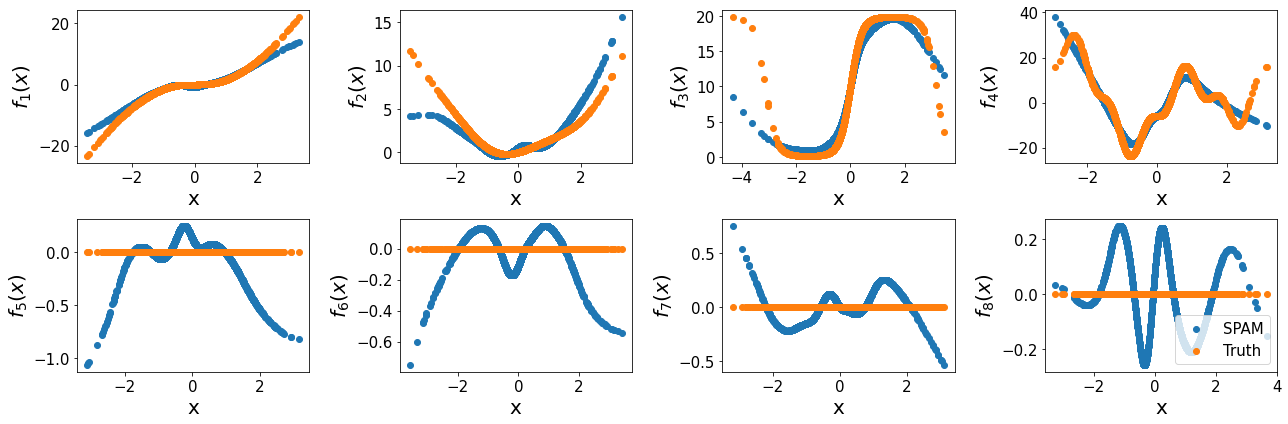

In [ ]:
for i in range(f_tr.shape[1]):
    if i < len(features):
        f_i = features[i](X_train[:, i])
    else: f_i = np.zeros_like(X_train[:, i])
    c_i=np.mean(f_tr[:,[i]]-f_i)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

i = 0
for row in axes:
    for col in row:
        if i < len(features):
            f_i = features[i](X_train[:, i])
        else: 
            f_i = np.zeros_like(X_train[:, i])
        c_i=np.mean(f_tr[:,[i]]-f_i) 

        col.scatter(X_train[:, i], f_tr[:, [i]]-c_i, label='SPAM')
        col.scatter(X_train[:, i], f_i, label='Truth')
        if i == 7:
            col.legend(fontsize='15', loc=4)
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel('x', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig(path+'plot_synRG_spam.pdf', bbox_inches='tight')
plt.show()        

## Finally, SNAM!

In [16]:
## best features used by freyberger et al:
features_freyberger = ['d_shrout', 'd_so', 'investment', 'lme', 'lturnover', 
                       'pm_adj', 'cum_return_1_0', 'cum_return_12_2', 'cum_return_12_7', 
                       'rel_to_high_price', 'roc','suv', 'total_vol','TARGET']
features_rf = ['d_shrout', 'roe', 'oa', 'free_cf', 'nop', 'dpi2a', 'rna', 'ato', 'd_dgm_dsales', 'roc', 'ipm', 'spread_mean', 'dto', 'suv', 'TARGET']
features_ae = ['e2p', 'beme', 'cum_return_12_2', 'cum_return_12_7', 'mm_sin', 'mm_cos', 'yy', 'dpi2a', 'ret', 'total_vol', 'noa', 'std_volume', 'dto', 'cto', 'TARGET']

In [14]:
print(len(features_rf), " - ", len(features_ae), " - ", len(features_freyberger))

15  -  15  -  14


In [60]:
# Load subsample data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_data(fullsample_path, feature_selector=features_freyberger)
X_train.shape

(558274, 13)

In [63]:
print(X_train.shape,
     X_valid.shape,
     X_test.shape)

(67126, 13) (17481, 13) (36584, 13)


### SNAM

#### Training using different selected features

In [41]:
iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], y_train, plot=True)

ValueError: Data must be 1-dimensional

In [62]:
wandb.finish()

current_lr,▁
learning_rate,▁
max_epochs,▁
n_features,▁
current_lr,0.003
learning_rate,0.005
max_epochs,100
n_features,13
optimizer,Adam


In [63]:
### TRAINING WITH SAMPLENET AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 2, 5e-3, int(100), True, X_train.shape[1] # lbd = lambda for regularization
trainloader, testloader, output_size = data_totensor2(X_train, X_valid, y_train, y_valid, batch_size=512, MSE=MSE) #batch 256

start = time.time()
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE)
time_spent =  time.time()-start 

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], y_train, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)
#print('iden error: ', iden_error)

training with lbd:  2
Training on: cuda:0
################################## START OF TRAINING ##################################
##### Training Epoch Nr: 0 started ####


1091it [00:21, 50.40it/s]
1091it [00:21, 49.79it/s]
1091it [00:21, 49.85it/s]
1091it [00:21, 50.17it/s]
1091it [00:21, 50.34it/s]


##### Training Epoch Nr: 5 started ####


1091it [00:21, 50.07it/s]
1091it [00:22, 48.94it/s]
1091it [00:22, 48.71it/s]
1091it [00:22, 48.41it/s]
1091it [00:22, 48.23it/s]


test loss : 0.030130484190662034
epoch:  10 Loss train:  0.01529053724063586 Loss test:  0.030130484190662034
##### Training Epoch Nr: 10 started ####


1091it [00:22, 48.44it/s]
1091it [00:22, 48.95it/s]
1091it [00:22, 47.54it/s]
1091it [00:23, 47.27it/s]
1091it [00:23, 46.34it/s]


##### Training Epoch Nr: 15 started ####


1091it [00:23, 46.33it/s]
1091it [00:23, 45.90it/s]
1091it [00:23, 46.30it/s]
1091it [00:23, 46.30it/s]
1091it [00:23, 46.30it/s]


test loss : 0.030924229537889075
epoch:  20 Loss train:  0.014985629608794897 Loss test:  0.030924229537889075
##### Training Epoch Nr: 20 started ####


1091it [00:23, 46.24it/s]
1091it [00:23, 45.95it/s]
1091it [00:23, 46.30it/s]
1091it [00:24, 45.10it/s]
1091it [00:28, 38.66it/s]


##### Training Epoch Nr: 25 started ####


1091it [00:28, 38.62it/s]
1091it [00:24, 45.38it/s]
1091it [00:22, 48.67it/s]
1091it [00:22, 48.45it/s]
1091it [00:23, 47.39it/s]


test loss : 0.03046912228455767
epoch:  30 Loss train:  0.014831662443521972 Loss test:  0.03046912228455767
##### Training Epoch Nr: 30 started ####


1091it [00:22, 48.23it/s]
1091it [00:22, 48.57it/s]
1091it [00:22, 48.57it/s]
1091it [00:22, 48.94it/s]
1091it [00:22, 48.38it/s]


##### Training Epoch Nr: 35 started ####


1091it [00:22, 48.56it/s]
1091it [00:22, 48.46it/s]
1091it [00:22, 48.72it/s]
1091it [00:22, 49.04it/s]
1091it [00:22, 48.68it/s]


test loss : 0.03002376189061369
epoch:  40 Loss train:  0.014807767037124699 Loss test:  0.03002376189061369
##### Training Epoch Nr: 40 started ####


1091it [00:22, 49.07it/s]
1091it [00:22, 48.65it/s]
1091it [00:22, 49.19it/s]
1091it [00:22, 49.09it/s]
1091it [00:22, 49.20it/s]


##### Training Epoch Nr: 45 started ####


1091it [00:22, 48.53it/s]
1091it [00:22, 49.16it/s]
1091it [00:22, 48.82it/s]
1091it [00:22, 49.20it/s]
1091it [00:22, 48.75it/s]


test loss : 0.030054805809273742
epoch:  50 Loss train:  0.014732581838593228 Loss test:  0.030054805809273742
##### Training Epoch Nr: 50 started ####


1091it [00:22, 48.66it/s]
1091it [00:22, 47.65it/s]
1091it [00:23, 45.88it/s]
1091it [00:24, 44.84it/s]
1091it [00:23, 45.53it/s]


##### Training Epoch Nr: 55 started ####


1091it [00:23, 45.64it/s]
1091it [00:23, 46.05it/s]
1091it [00:23, 46.02it/s]
1091it [00:23, 45.81it/s]
1091it [00:22, 48.20it/s]


test loss : 0.029993794464434568
epoch:  60 Loss train:  0.014790703875450614 Loss test:  0.029993794464434568
##### Training Epoch Nr: 60 started ####


1091it [00:23, 46.84it/s]
1091it [00:23, 46.29it/s]
1091it [00:22, 48.67it/s]
1091it [00:22, 48.39it/s]
1091it [00:22, 48.79it/s]


##### Training Epoch Nr: 65 started ####


1091it [00:22, 48.73it/s]
1091it [00:22, 48.75it/s]
1091it [00:22, 48.60it/s]
1091it [00:22, 48.62it/s]
1091it [00:22, 48.93it/s]


test loss : 0.029990324925165623
epoch:  70 Loss train:  0.014817295714659662 Loss test:  0.029990324925165623
##### Training Epoch Nr: 70 started ####


1091it [00:22, 48.73it/s]
1091it [00:22, 49.16it/s]
1091it [00:22, 49.03it/s]
1091it [00:22, 49.07it/s]
1091it [00:22, 48.98it/s]


##### Training Epoch Nr: 75 started ####


1091it [00:22, 49.08it/s]
1091it [00:22, 48.99it/s]
1091it [00:22, 49.14it/s]
1091it [00:22, 48.82it/s]
1091it [00:22, 48.78it/s]


test loss : 0.030018867906899407
epoch:  80 Loss train:  0.014913395358766852 Loss test:  0.030018867906899407
##### Training Epoch Nr: 80 started ####


1091it [00:22, 48.59it/s]
1091it [00:22, 48.48it/s]
1091it [00:22, 48.59it/s]
1091it [00:22, 47.87it/s]
1091it [00:22, 48.53it/s]


##### Training Epoch Nr: 85 started ####


1091it [00:22, 48.19it/s]
1091it [00:25, 43.46it/s]
1091it [00:28, 38.79it/s]
1091it [00:28, 38.73it/s]
1091it [00:28, 38.67it/s]


test loss : 0.029988717529564522
epoch:  90 Loss train:  0.015162385286085519 Loss test:  0.029988717529564522
##### Training Epoch Nr: 90 started ####


1091it [00:28, 38.31it/s]
1091it [00:28, 38.45it/s]
1091it [00:28, 38.62it/s]
1091it [00:28, 38.74it/s]
1091it [00:27, 39.91it/s]


##### Training Epoch Nr: 95 started ####


1091it [00:22, 48.08it/s]
1091it [00:22, 48.13it/s]
1091it [00:22, 48.02it/s]
1091it [00:22, 48.15it/s]
1091it [00:22, 48.35it/s]


test loss : 0.029986759826827507
epoch:  100 Loss train:  0.015319085387362801 Loss test:  0.029986759826827507
f_tr_out:  [[ 3.8437051e-06]
 [ 0.0000000e+00]
 [-5.9070209e-07]
 [-1.4567045e-05]
 [ 0.0000000e+00]
 [-1.3161880e-05]
 [ 1.6884247e-05]
 [-1.8480869e-05]
 [-4.3614205e-06]
 [-6.9640951e-06]
 [-1.1101060e-04]
 [ 0.0000000e+00]
 [ 1.1645562e-05]]
time spent:  2578.3501312732697  sec
test loss:  0.029986759826827507


/scratch/slurm_tmpdir/job_20873679/ipykernel_3139408/2038285969.py:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model, epoch_train_loss_history, epoch_test_loss_history]


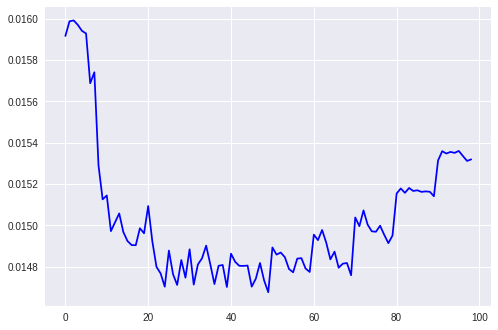

In [64]:
#plt.style.use("seaborn")
plt.plot(train_loss_history[1:], c='b')
#plt.savefig('train_history_77')

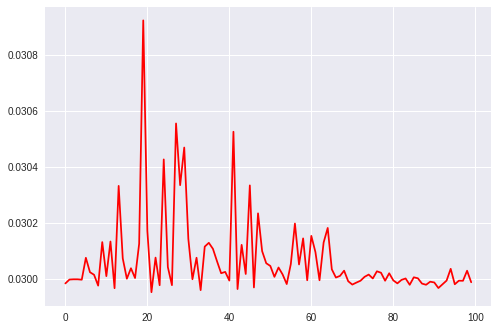

In [66]:
plt.plot(test_loss_history, c='r')
#plt.savefig('val_history_71')

In [67]:
rmse, mae, mse, outputs, targets, f_te = predict_and_evaluate_model(model, testloader)
print(f'Test performance: RMSE: {rmse}, MAE: {mae}, MSE: {mse}')
wandb.finish()

Test performance: RMSE: 0.31288713216781616, MAE: 0.21218298375606537, MSE: 0.0980510413646698


Loss test:,▁▁▂▂▂▁▁▂▃▂▂█▃▁▃▂▁▃▅▃▂▂▂▃▃▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁
Train Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
current_lr,█▅▃▂▂▁▁▁▁▁
learning_rate,▁
mae_test,▁
max_epochs,▁
mse_test,▁
n_features,▁
rmse_test,▁
Loss test:,0.02999
Train Loss,0.01532


In [69]:
print("Mean preds: ", np.mean(outputs), "; Mean targets", np.mean(targets))

Mean preds:  0.016775755 ; Mean targets 0.1754364


In [52]:
plot_shape_functions(f_out_tr, save=True, run_id=77)

NameError: name 'plot_shape_functions' is not defined

In [24]:
print(model.)

AttributeError: module 'torch.optim' has no attribute 'param_groups'

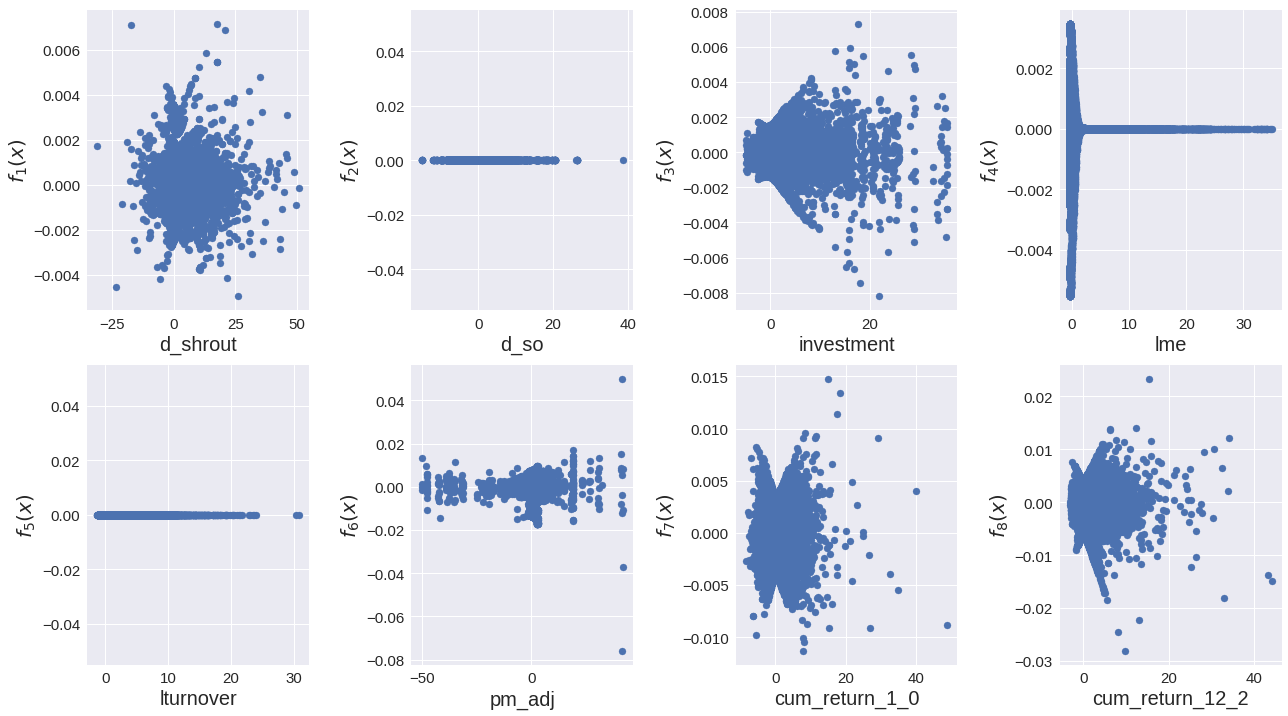

In [72]:
# Features are the ground truth, in case of Xu et al. they used
# four functions that they try to imitate, since I dont have
# a true function y is used instead
plt.style.use("seaborn")
columns = X_train.columns
features = n_features

f_tr = f_out_tr

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))

i = 0
for row in axes:
    for col in row: 

        col.scatter(X_train.iloc[:, i], f_tr[:, [i]], label='SNAM')
        #if i == 5:
        #    col.legend(fontsize='15')
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel(f'{columns[i]}', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig('plot_shapes_snam_77.png', bbox_inches='tight')
plt.show()        

In [ ]:
visualize_

### Try reload and predict again

In [35]:
saved_model = torch.load('./models/model_60.pth')

In [53]:
print(device)

cuda:0


In [39]:
rmse, mae, mse, outputs, targets, f_te = predict_and_evaluate_model(saved_model, testloader, wandb_log=False)
print(f'Test performance: RMSE: {rmse}, MAE: {mae}, MSE: {mse}')

Test performance: RMSE: 0.2081463783979416, MAE: 0.130947083234787, MSE: 0.04330037906765938


In [57]:
### TRANSFER LEARNING USING LOADED MODEL ON DIFFERENT FEATURES ###

X_train, X_valid, X_test, y_train, y_valid, y_test = load_data(subsample_large, feature_selector=features_ae)

lbd, lr, max_epoch, MSE, n_features = 2, 5e-3, int(100), True, X_train.shape[1] #, torch.optim.Adam(model.parameters(), lr = lr) # lbd = lambda for regularization
trainloader, testloader, output_size = data_totensor2(X_train, X_valid, y_train, y_valid, batch_size=256, MSE=MSE)

start = time.time()
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE, model=saved_model, loaded=True)
#train_sub(trainloader, testloader,n_features, saved_model.to(device) , optimizer,max_epoch)
time_spent =  time.time()-start 

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], y_train, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)
#print('iden error: ', iden_error)

training with lbd:  2


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [27]:
### Helper method to visualize prediction vs true values
import matplotlib.pyplot as plt
import random
plt.style.use("seaborn")

#permnos_total = X_train.index.droplevel(['permno'])

def visualize_sample_prediction(y_test, y_pred):
    # Picks a random stock, to visualize its real returns 
    # against the predicted returns
    #sample_permno = random.choice(permnos_total)
    ## delete:
    #sample_permno = 51625
    #sample_test_y = y_test.xs(sample_permno, level='permno')
    idx = X_valid.index.droplevel(['permno'])
    #sample_test_idx = sample_test_y.index.get_level_values('date')
    print(len(idx))
    #y_pred = pd.Series(y_pred, index=y_test.index)
    #sample_pred = y_pred.xs(sample_permno, level='permno')
    print(len(y_test))
    fig,ax=plt.subplots(figsize=(18,6))

    ax.scatter(x=idx, y= y_valid, color='r')
    ax.scatter(x=idx, y= y_pred, color='b')
    plt.title(f'Stock nr {sample_permno} predicted returns (blue) vs actual returns (red)')

In [87]:
X_train.head()

,,d_shrout,roe,oa,free_cf,nop,dpi2a,rna,ato,d_dgm_dsales,roc,ipm,spread_mean,dto,suv
date,permno,,,,,,,,,,,,,,
1963-07-31,25478,0.0,1.376665,-0.157156,1.339988,0.455536,-1.414202,1.41317,1.393337,-0.045121,0.968147,1.409418,0.906757,1.352097,1.408824
1963-08-31,25478,0.0,1.376665,-0.157156,1.339988,0.455536,-1.414202,1.41317,1.393337,-0.045121,0.968147,1.409418,1.241720,-1.395851,-1.371609
1963-09-30,25478,0.0,1.376665,-0.157156,1.339988,0.455536,-1.414202,1.41317,1.393337,-0.045121,0.968147,1.409418,0.932829,0.383929,-1.194858
1963-10-31,25478,0.0,1.376665,-0.157156,1.339988,0.455536,-1.414202,1.41317,1.393337,-0.045121,0.968147,1.409418,0.454836,-0.535886,-0.257600
1963-11-30,25478,0.0,1.376665,-0.157156,1.339988,0.455536,-1.414202,1.41317,1.393337,-0.045121,0.968147,1.409418,1.187341,0.598086,-1.414213


In [96]:
type(f_out_tr)

numpy.ndarray

#### Training with samplenet as subnets #### 

In [40]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
count=0
for p in model.parameters():
  count += sum(np.abs(p.detach().cpu().flatten())>0.01)
print('non-zero #of params %i / %i' % (count, total_params))

non-zero #of params 61952 / 68901


In [ ]:
### TRAINING WITH SAMPLENET AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 2, 5e-3, int(100), True, X_train.shape[1] # lbd = lambda for regularization
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid, batch_size=256, MSE=MSE)

start = time.time()
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE)
time_spent =  time.time()-start 

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], features, plot=True)
#print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)
#wandb.log({"execution_time" : time_spent})
#wandb.finish()

#print('precision: ', precision_score(true_feature,np.mean(np.abs(f_out_tr), axis=0)>0.01))
#print('recall: ', recall_score(true_feature,np.mean(np.abs(f_out_tr), axis=0)>0.01))
#print('iden error: ', iden_error)

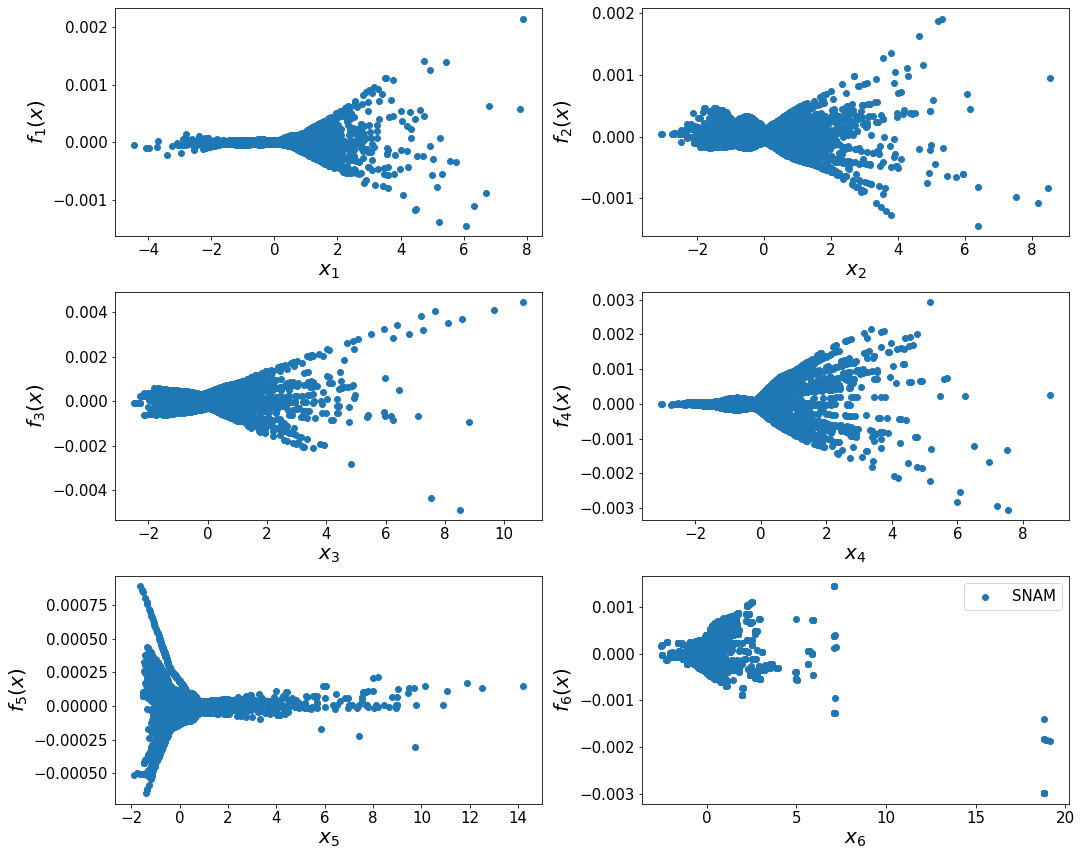

In [43]:
plot_shape_functions(f_out_tr, save=True, run_id=69)

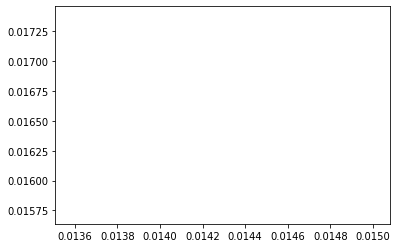

In [ ]:
plt.plot(train_loss_history, test_loss_history)

In [ ]:
##%%save
f = open(path+"plot_synRG_snam.pkl","wb")
pickle.dump([test_loss, f_out_tr, f_out_te, model], f)
f.close()

# ##%%load
#[test_loss, f_out_tr, f_out_te, model] = \
#pickle.load(open(path+"plot_synRG_snam.pkl", "rb"))

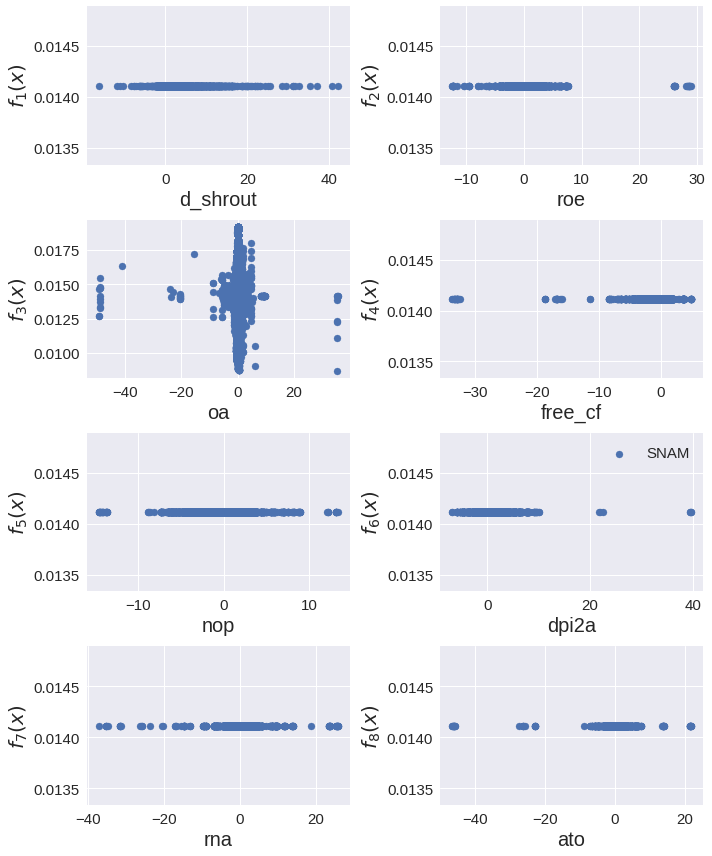

In [150]:
plot_shape_functions(f_out_tr, save=True)

In [143]:
X_train.columns[0]

'd_shrout'

In [21]:
#feature_names = ch_data.feature_names
features = y_train

def plot_shape_functions(f_out_tr, save=False, run_id=""):
    feature_names = X_train.columns
    # Plot shape functions
    f_tr = f_out_tr
    for i in range(8):
        if i < y_train.shape[0]:
            f_i = y_train.to_numpy().reshape(-1,1) #if y is pd.series
        else: f_i = np.zeros_like(X_train[:, i])
        #print(f_i.shape, "-", f_tr.shape)
        c_i=np.mean(f_tr[:,[i]]-f_i)

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 12))

    i = 0
    for row in axes:
        for col in row:
            if i < y_train.shape[0]:
                f_i = y_train.to_numpy().reshape(-1,1) #if y is pd.series
            else: 
                f_i = np.zeros_like(X_train[:, i])
            c_i=np.mean(f_tr[:,[i]]-f_i) 
            col.scatter(X_train.iloc[:, i], f_tr[:, [i]]-c_i, label='SNAM')
            #col.scatter(X_train, features[i](X_train))
            if i == 5:
                col.legend(fontsize='15')
            col.xaxis.set_tick_params(labelsize=15)
            col.yaxis.set_tick_params(labelsize=15)
            col.set_xlabel(f'{feature_names[i]}', fontsize='20')
            col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
            i += 1

    fig.tight_layout()
    if save:
        fig.savefig(path+'shape_functions_snam_'+str(run_id)+'.png', bbox_inches='tight')
    plt.show()  

#### Training with Pyramidnet as Subnetworks

In [17]:
### TRAINING WITH Pyramidnet AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 2, 5e-3, int(100), True, X_train.shape[1] # what is lbd??
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid, batch_size=256, MSE=MSE)

start = time.time()
[test_loss, f_out_tr_2, f_out_te, model, train_loss_history, test_loss_history] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE, pyramid=True)
time_spent =  time.time()-start 

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], features, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)

NameError: name 'X_train' is not defined

In [94]:
print(train_loss_history)

[0.7453324684729943]


## California housing

In [13]:
from sklearn.model_selection import train_test_split
ch_data = sklearn.datasets.fetch_california_housing()

X = ch_data.data
y = ch_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
print(X_train.shape, X_test.shape)

(16512, 8) (4128, 8)


In [15]:
def data_totensor(X_train, X_test, y_train, y_test, batch_size = 256, batch_size_test=1000,save=False, MSE=True):
    
    #%% separate data into three parts: train, validation(?) and test. 
    if MSE: 
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)
        D_out = 1
    else:
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).long()
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).long()
        D_out = 2

    Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=False)
    Test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size_test, shuffle=False)
    
    if save== True:
        f = open(path+"data/p2_data.pkl","wb")
        pickle.dump([trainloader, valloader, testloader, D_out], f)
        f.close()
    
    return trainloader, testloader, D_out 

In [46]:
### TRAINING WITH SampleNet AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 1, 10e-5, int(100), True, X_train.shape[1] # lambda
trainloader, testloader, output_size = data_totensor(X_train, X_test, y_train, y_test, batch_size=256, MSE=MSE)

start = time.time()
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE)
time_spent =  time.time()-start 

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], features, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)

Loss test:,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁
max_epochs,▁
n_features,▁
Loss test:,0.53314
Train Loss,0.54203
learning_rate,0.0001
max_epochs,50
n_features,8
optimizer,Adam


training with lbd:  1
Training on: cuda:0
################################## START OF TRAINING ##################################
##### Training Epoch Nr: 0 started ####
Early stopping counter:  0


65it [00:00, 87.50it/s]
65it [00:00, 88.23it/s]
65it [00:00, 87.35it/s]
65it [00:00, 67.79it/s]
65it [00:00, 87.81it/s]


##### Training Epoch Nr: 5 started ####
Early stopping counter:  0


65it [00:00, 87.89it/s]
65it [00:00, 88.13it/s]
65it [00:00, 87.77it/s]
65it [00:00, 87.99it/s]
65it [00:00, 88.32it/s]


test loss : 0.8756058931350708
epoch:  10 Loss train:  0.9238719188250029 Loss test:  0.8756058931350708
##### Training Epoch Nr: 10 started ####
Early stopping counter:  0


65it [00:00, 87.84it/s]
65it [00:00, 87.70it/s]
65it [00:00, 87.78it/s]
65it [00:00, 88.30it/s]
65it [00:00, 88.38it/s]


##### Training Epoch Nr: 15 started ####
Early stopping counter:  0


65it [00:00, 87.58it/s]
65it [00:00, 88.18it/s]
65it [00:00, 87.75it/s]
65it [00:00, 88.26it/s]
65it [00:00, 87.54it/s]


test loss : 0.6306632041931153
epoch:  20 Loss train:  0.6346596612380101 Loss test:  0.6306632041931153
##### Training Epoch Nr: 20 started ####
Early stopping counter:  0


65it [00:00, 87.50it/s]
65it [00:00, 87.95it/s]
65it [00:00, 88.04it/s]
65it [00:00, 88.23it/s]
65it [00:00, 88.19it/s]


##### Training Epoch Nr: 25 started ####
Early stopping counter:  0


65it [00:00, 70.62it/s]
65it [00:00, 88.55it/s]
65it [00:00, 87.80it/s]
65it [00:00, 87.86it/s]
65it [00:00, 88.38it/s]


test loss : 0.5862131774425506
epoch:  30 Loss train:  0.5808775567091429 Loss test:  0.5862131774425506
##### Training Epoch Nr: 30 started ####
Early stopping counter:  0


65it [00:00, 87.34it/s]
65it [00:00, 87.95it/s]
65it [00:00, 87.85it/s]
65it [00:00, 87.94it/s]
65it [00:00, 88.30it/s]


##### Training Epoch Nr: 35 started ####
Early stopping counter:  0


65it [00:00, 87.71it/s]
65it [00:00, 87.99it/s]
65it [00:00, 88.08it/s]
65it [00:00, 87.31it/s]
65it [00:00, 85.87it/s]


test loss : 0.5434629917144775
epoch:  40 Loss train:  0.5521023974968837 Loss test:  0.5434629917144775
##### Training Epoch Nr: 40 started ####
Early stopping counter:  0


65it [00:00, 85.05it/s]
65it [00:00, 85.61it/s]
65it [00:00, 85.84it/s]
65it [00:00, 68.89it/s]
65it [00:00, 86.43it/s]


##### Training Epoch Nr: 45 started ####
Early stopping counter:  0


65it [00:00, 86.24it/s]
65it [00:00, 86.22it/s]
65it [00:00, 86.21it/s]
65it [00:00, 86.45it/s]
65it [00:00, 85.88it/s]


test loss : 0.5331398665904998
epoch:  50 Loss train:  0.5420332390528458 Loss test:  0.5331398665904998
##### Training Epoch Nr: 50 started ####
Early stopping counter:  0


65it [00:00, 85.66it/s]
65it [00:00, 86.32it/s]
65it [00:00, 86.45it/s]
65it [00:00, 85.91it/s]
65it [00:00, 86.20it/s]


##### Training Epoch Nr: 55 started ####
Early stopping counter:  0


65it [00:00, 85.33it/s]
65it [00:00, 86.01it/s]
65it [00:00, 85.89it/s]
65it [00:00, 85.83it/s]
65it [00:00, 69.29it/s]


test loss : 0.537965452671051
epoch:  60 Loss train:  0.5497660875320435 Loss test:  0.537965452671051
##### Training Epoch Nr: 60 started ####
Early stopping counter:  0


65it [00:00, 86.00it/s]
65it [00:00, 85.81it/s]
65it [00:00, 85.99it/s]
65it [00:00, 86.24it/s]
65it [00:00, 86.08it/s]


##### Training Epoch Nr: 65 started ####
Early stopping counter:  0


65it [00:00, 85.65it/s]
65it [00:00, 86.12it/s]
65it [00:00, 85.79it/s]
65it [00:00, 85.76it/s]
65it [00:00, 85.99it/s]


test loss : 0.5367823481559754
epoch:  70 Loss train:  0.5513448719794933 Loss test:  0.5367823481559754
##### Training Epoch Nr: 70 started ####
Early stopping counter:  0


65it [00:00, 86.00it/s]
65it [00:00, 86.02it/s]
65it [00:00, 85.84it/s]
65it [00:00, 86.26it/s]
65it [00:00, 85.77it/s]


##### Training Epoch Nr: 75 started ####
Early stopping counter:  0


65it [00:00, 85.88it/s]
65it [00:00, 86.10it/s]
65it [00:00, 86.33it/s]
65it [00:00, 86.19it/s]
65it [00:00, 86.80it/s]


test loss : 0.6310888409614563
epoch:  80 Loss train:  0.6264799938752101 Loss test:  0.6310888409614563
##### Training Epoch Nr: 80 started ####
Early stopping counter:  0


65it [00:00, 85.55it/s]
65it [00:00, 85.91it/s]
65it [00:00, 85.76it/s]
65it [00:00, 86.24it/s]
65it [00:00, 85.96it/s]


##### Training Epoch Nr: 85 started ####
Early stopping counter:  0


65it [00:00, 86.25it/s]
65it [00:00, 84.85it/s]
65it [00:00, 86.10it/s]
65it [00:00, 86.38it/s]
65it [00:00, 86.13it/s]


test loss : 0.9169337034225464
epoch:  90 Loss train:  0.7557392285420345 Loss test:  0.9169337034225464
##### Training Epoch Nr: 90 started ####
Early stopping counter:  0


65it [00:00, 85.69it/s]
65it [00:00, 85.61it/s]
65it [00:00, 85.89it/s]
65it [00:00, 86.05it/s]
65it [00:00, 85.69it/s]


##### Training Epoch Nr: 95 started ####
Early stopping counter:  0


65it [00:00, 85.59it/s]
65it [00:00, 86.27it/s]
65it [00:00, 66.83it/s]
65it [00:00, 86.21it/s]
65it [00:00, 85.91it/s]

test loss : 0.8956698536872864
epoch:  100 Loss train:  0.7484330525765053 Loss test:  0.8956698536872864
f_tr_out:  [[ 1.2371765e+00]
 [ 4.9560669e-01]
 [-9.3930257e-06]
 [-1.4443558e-06]
 [-8.3350455e-03]
 [-1.4335108e-06]
 [-1.3821381e+00]
 [ 1.7210741e+00]]
time spent:  86.20256662368774  sec
test loss:  0.8956698536872864



/scratch/slurm_tmpdir/job_20991135/ipykernel_2718888/284834048.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model, epoch_train_loss_history, epoch_test_loss_history]


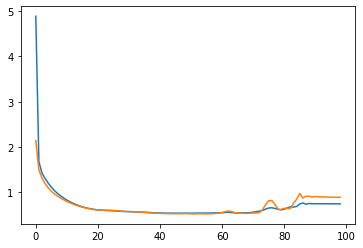

In [47]:
plt.plot(train_loss_history[1:])
plt.plot(test_loss_history[1:])
#plt.savefig()

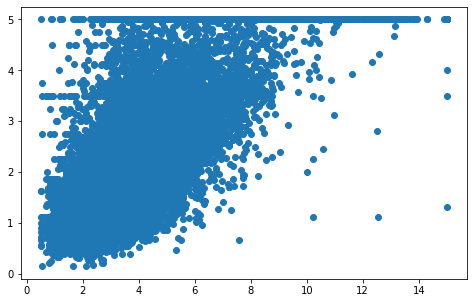

In [68]:
y_smooth = pd.Series(y_train).rolling(18).mean()
plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], y_train)

In [69]:
f_out_tr.shape

(16512, 8, 1)

In [19]:
def load_model(model_dir, run_id):
    model = torch.load(f'{model_dir}model_{run_id}.pth')
    return model

In [20]:
# do one forward pass
model_dir = "./models/SNAM/"
run_id = '84_ch'
pretrained_model = load_model(model_dir, run_id)

AttributeError: Can't get attribute 'NAM' on <module '__main__'>

In [ ]:
# do one forward pass
for idx1, (inputs, targets) in tqdm(enumerate(trainloader)): 
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, f_out_tr_temp = model(inputs)[0],model(inputs)[1].detach().cpu().numpy()

In [27]:
feature_names = ch_data.feature_names
res_path = './results'

# Plot shape functions
def plot_CH_shape_functions(X, y, f_tr, feature_names, res_path=res_path):
    features = y
    for i in range(f_tr.shape[1]):
        if i < y.shape[0]:
            f_i = y
        else: f_i = np.zeros_like(X[:, i])
        c_i=np.mean(f_tr[:,[i]]-f_i)

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))

    i = 0
    for row in axes:
        for col in row:
            if i < y.shape[0]:
                f_i = y
            else: 
                f_i = np.zeros_like(X[:, i])
            c_i=np.mean(f_tr[:,[i]]-f_i) 
            col.scatter(X[:, i], f_tr[:, [i]]-c_i, label='SNAM')
            #col.scatter(X_train, features[i](X_train))
            if i == 8:
                col.legend(fontsize='15')
            col.xaxis.set_tick_params(labelsize=15)
            col.yaxis.set_tick_params(labelsize=15)
            col.set_xlabel(f'{feature_names[i]}', fontsize='20')
            col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
            i += 1

    fig.tight_layout()
    fig.savefig(res_path+'plot_CH_snam.png', bbox_inches='tight')
    plt.show()        

In [30]:
print(X_train.shape, " - ", f_out_tr.shape)

(16512, 8)  -  (16512, 8, 1)


In [29]:
print(X_test.shape, " - ", f_out_te.shape)

(4128, 8)  -  (1024, 1)


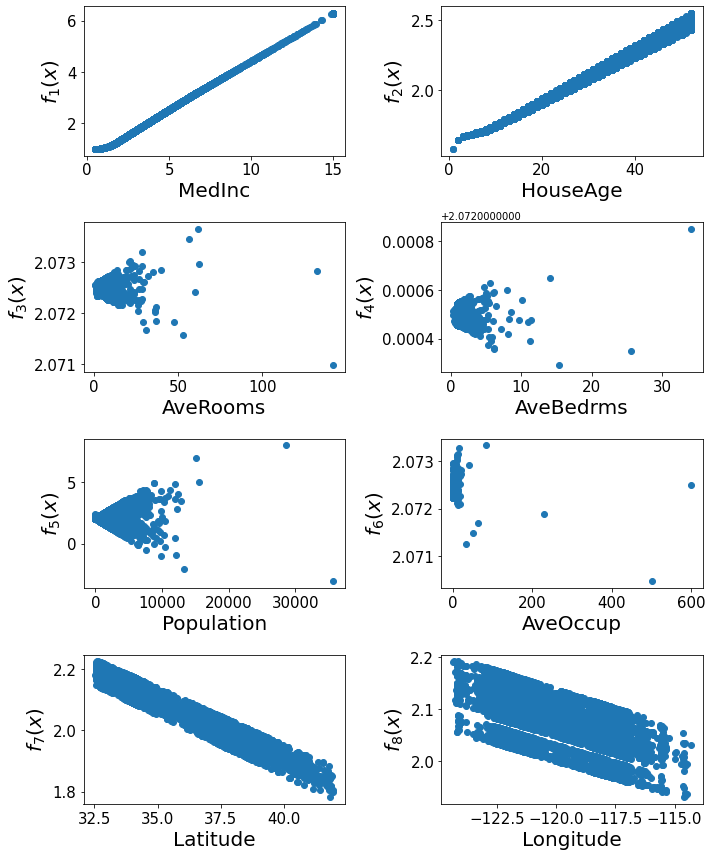

In [48]:
plot_CH_shape_functions(X_train, y_train, f_out_tr, feature_names)

Notice:
Cannot reproduce plots from paper on California Housing dataset.
-> Something might be off with the plot function...